#Projet réalisé par 

*   DIDIER Adrien - 21609811 
*   MARTIN Loïc - 21605214

# **Préparer les données**

**Monter le dossier dans Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Projet_HMIN339M')

### **Importation de quelques librairies**

In [ ]:
import numpy as np
import tifffile
import glob
from pathlib import Path
import pandas as pd

### **Lecture de la série temporelle d'images et Normalisation par bande sur la série temporelle entre 0 et 1**


#### **Création du tableau contenant les labels**


In [ ]:
labels = ["Zones urbaines", "Eau", "Forêt", "Landes","Cultures"]


#### **Lecture des images et création des séries temporelles de bandes**


In [ ]:
# Récupérer la liste des images
lst_img = glob.glob ('Images/*.tif')
lst_img.sort() # ordonner par date si ce n'est pas le cas
lst_img

['Images/20160322_S2A.tif',
 'Images/20160710_S2A.tif',
 'Images/20160730_S2A.tif',
 'Images/20160928_S2A.tif',
 'Images/20161018_S2A.tif',
 'Images/20161127_S2A.tif',
 'Images/20161217_S2A.tif',
 'Images/20161227_S2A.tif']

In [ ]:
# Lecture de la bande du rouge (B1) pour toute la série temporelle
red_ts = []
for img in lst_img:
  red_ts.append( tifffile.imread(img)[:,:,0]) # Rouge
red_ts = np.dstack(red_ts)
red_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du vert (B2) pour toute la série temporelle
green_ts = []
for img in lst_img:
  green_ts.append( tifffile.imread(img)[:,:,1]) # Vert
green_ts = np.dstack(green_ts)
green_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du bleu (B3) pour toute la série temporelle
blue_ts = []
for img in lst_img:
  blue_ts.append( tifffile.imread(img)[:,:,2]) # Bleu
blue_ts = np.dstack(blue_ts)
blue_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du proche infrarouge (B4) pour toute la série temporelle
nir_ts = []
for img in lst_img:
  nir_ts.append( tifffile.imread(img)[:,:,3]) # Proche infra rouge
nir_ts = np.dstack(nir_ts)
nir_ts.shape

(5412, 5592, 8)

**Normalisation en utilisant le min et le max des bandes sur les séries temporelles**

In [ ]:
# Normalisation des séries temporelles par bande: Rouge
red_ts_norm = ( red_ts - red_ts.min() ) / ( red_ts.max() - red_ts.min() ).astype(np.float32)
red_ts_norm.min() , red_ts_norm.max(), red_ts_norm.shape, red_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Vert
green_ts_norm = ( green_ts - green_ts.min() ) / ( green_ts.max() - green_ts.min() ).astype(np.float32)
green_ts = None
green_ts_norm.min() , green_ts_norm.max(), green_ts_norm.shape, green_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Bleu
blue_ts_norm = ( blue_ts - blue_ts.min() ) / ( blue_ts.max() - blue_ts.min() ).astype(np.float32)
blue_ts = None
blue_ts_norm.min() , blue_ts_norm.max(), blue_ts_norm.shape, blue_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Proche infrarouge
nir_ts_norm = ( nir_ts - nir_ts.min() ) / ( nir_ts.max() - nir_ts.min() ).astype(np.float32)
nir_ts_norm.min() , nir_ts_norm.max(), nir_ts_norm.shape, nir_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

### **Lecture de la vérité terrain et récupération des positions des pixels du jeu d'entraînement et de test**


#### **Lecture des fichiers de la vérité terrain**

In [ ]:
# Lire le fichier correspondant aux classes d'occupation du sol
gt_class = tifffile.imread ('Verite_terrain/DORDOGNE_VT_CLASS.tif')
gt_class.shape , gt_class.dtype

((5412, 5592), dtype('uint8'))

In [ ]:
# Lire le fichier correspondant aux identifiants
gt_id = tifffile.imread ('Verite_terrain/DORDOGNE_VT_ID.tif')
gt_id.shape, gt_id.dtype

((5412, 5592), dtype('int16'))

#### **Récupération des positions des pixels d'entraînement et de test**

In [ ]:
# Récupérer les positions des échantillons d'entraînement et test
idx_train_ = np.where ( (gt_id!=0) & (gt_class!=0) )
idx_test = np.where ( (gt_id!=0) & (gt_class==0) )

In [ ]:
# Lecture des identifiants et labels des échantillons d'entraînement
train_id_ = gt_id[idx_train_]
train_y_ = gt_class[idx_train_]
f'échantillons d\'entrainement: {train_y_.shape[0]} pixels, {len(np.unique(train_id_))} objets'

"échantillons d'entrainement: 605431 pixels, 1859 objets"

In [ ]:
# Lecture des identifiants et labels des échantillons de test
test_id = gt_id[idx_test]
f'échantillons test: {test_id.shape[0]} pixels, {len(np.unique(test_id))} objets'

'échantillons test: 207485 pixels, 800 objets'

**Création d'un jeu de validation en prenant une partie du jeu d'entraînement**

In [ ]:
# Dataframe pour créer un jeu de validation
samples = pd.DataFrame({'ID':train_id_,'Class':train_y_})
samples = samples.drop_duplicates(keep='first')
samples.head(5)

,ID,Class
0,422,2
4,2677,5
5,201,3
29,423,2
100,496,2


In [ ]:
# 30% des échantillons de chaque classe affecté au jeu de validation
train_id = []
valid_id = []
for c in np.unique(samples.Class.values) :
    samples_c = samples.loc[samples.Class==c]
    samples_frac = samples_c.sample(frac=0.7,random_state=1234) 
    train_id.extend( samples_frac.ID.values )
    valid_id.extend( samples_c.drop(samples_frac.index).ID.values )
len(train_id),len(valid_id)

(1301, 558)

### **Récupération des positions des nouveaux échantillons d'entraînement et de validation**

In [ ]:
# Récupérer les positions des nouveaux échantillons d'entraînement et validation
idx_train = np.where ( np.isin(gt_id,train_id) )
idx_valid = np.where ( np.isin(gt_id,valid_id) )

### **Lire finalement les labels correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [ ]:
train_y = gt_class[idx_train]
valid_y = gt_class[idx_valid]
test_y = gt_class[idx_test]
train_y.shape, valid_y.shape, test_y.shape

((451962,), (153469,), (207485,))

### **Lire finalement les identifiants correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [ ]:
# utile pour les aggrégations au niveau objet
# train_id_array = gt_id[idx_train] # Pas vraiment nécessaire pour les échantillons d'entraînements
valid_id_array = gt_id[idx_valid]
test_id_array = gt_id[idx_test]
#train_id_array.shape, 
valid_id_array.shape, test_id_array.shape

((153469,), (207485,))

### **Lire finalement les valeurs des séries temporelles correspondant aux nouveaux échantillons d'entraînement, de validation et test**

#### **Pour un CNN2D ou spatial avec exemple d'imagettes ou patchs de 5 sur 5 en largeur et hauteur**

In [ ]:
# Un CNN 2D ou spatial requiert un tableau 3D du type (nombre d'échantillons, largeur, hauteur, nombre de features= (nombre de dates x nombre de bandes) )
# Vous pouvez rajouter à la liste des bandes les indices spectraux normalisés que vous aurez calculé

# Training
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_train[0]
idx_row = idx_train[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
train_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  train_X.append(np.stack(lst,axis=-1).reshape(5,5,-1))
train_X = np.stack(train_X,axis=0)
train_X.shape

(451962, 5, 5, 32)

In [ ]:
# Validation
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_valid[0]
idx_row = idx_valid[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
valid_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  valid_X.append(np.stack(lst,axis=-1).reshape(5,5,-1))
valid_X = np.stack(valid_X,axis=0)
valid_X.shape

(153469, 5, 5, 32)

In [ ]:
# Test
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_test[0]
idx_row = idx_test[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
test_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  test_X.append(np.stack(lst,axis=-1).reshape(5,5,-1))
test_X = np.stack(test_X,axis=0)
test_X.shape

(207485, 5, 5, 32)

### **Sauvegarde des données d'entraînement, de validation et test en fichier numpy**

In [ ]:
# Ainsi de cette façon vous pourrez continuer directement avec la création des modèles et en libérant la mémoire de tout ce qui a été fait précédemment
Path('CNN2D/data').mkdir(exist_ok=True, parents=True)
np.save('CNN2D/data/train_X.npy',train_X)
np.save('CNN2D/data/train_y.npy',train_y)
# np.save('data/train_id.npy',train_id_array)

np.save('CNN2D/data/valid_X.npy',valid_X)
np.save('CNN2D/data/valid_y.npy',valid_y)
np.save('CNN2D/data/valid_id.npy',valid_id_array)

np.save('CNN2D/data/test_X.npy',test_X)
np.save('CNN2D/data/test_id.npy',test_id_array)

# **CNN2D**

### **Remontage de Drive et Importation de quelques librairies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Projet_HMIN339M')
import numpy as np
import pandas as pd
import keras
import tifffile
from pathlib import Path
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization, Flatten, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

### **Recharger les données d'entraînement, de validation et test en fichier numpy**

In [ ]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('CNN2D/data/train_X.npy')
train_y = np.load('CNN2D/data/train_y.npy')

valid_X = np.load('CNN2D/data/valid_X.npy')
valid_y = np.load('CNN2D/data/valid_y.npy')
valid_id = np.load('CNN2D/data/valid_id.npy')

test_X = np.load('CNN2D/data/test_X.npy')
test_id = np.load('CNN2D/data/test_id.npy')
train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, valid_id.shape, test_X.shape, test_id.shape

labels = ["Zones urbaines", "Eau", "Forêt", "Landes","Cultures"]

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_y)
train_y_enc = encoder.transform(train_y)
train_y_enc = keras.utils.to_categorical(train_y_enc, len(labels))

valid_y_enc = encoder.transform(valid_y)
valid_y_enc = keras.utils.to_categorical(valid_y_enc, len(labels))

np.unique(train_y), np.unique(train_y_enc), np.unique(valid_y), np.unique(valid_y_enc)

(array([1, 2, 3, 4, 5], dtype=uint8),
 array([0., 1.], dtype=float32),
 array([1, 2, 3, 4, 5], dtype=uint8),
 array([0., 1.], dtype=float32))

### **Définition séquentielle de votre modèle avec Keras**


In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(5, 5, 32)))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(5))
model.add(Activation('softmax'))

In [ ]:
# Afficher votre modèle
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 3, 3, 64)          18496     
_________________________________________________________________
activation_95 (Activation)   (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 2, 2, 32)          18464     
_________________________________________________________________
activation_96 (Activation)   (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 2, 2, 32)          0         
_________________________________________________________________
global_average_pooling2d_17  (None, 32)              

### **Compiler votre modèle en définissant une fonction de côut, un optmiseur et une métrique**


In [ ]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )


### **Définition du callback**

In [ ]:
Path('CNN2D/my_model').mkdir(exist_ok=True, parents=True)
checkpointpath = os.path.join('CNN2D/my_model','model') # chemin où sauver le modèle
callbacks = [tf.keras.callbacks.ModelCheckpoint(
              checkpointpath,
              verbose=1, # niveau de log
              monitor='val_accuracy', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

### **Entraînement du modèle**


In [ ]:
BATCH_SIZE = 256
EPOCHS = 20
hist = model.fit(train_X, train_y_enc, validation_data=(valid_X,valid_y_enc), epochs = EPOCHS, batch_size = BATCH_SIZE, callbacks=callbacks)


Epoch 1/20
1764/1766 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.8702
Epoch 00001: val_accuracy improved from -inf to 0.90299, saving model to CNN2D/my_model/model
1766/1766 [==============================] - 32s 18ms/step - loss: 0.3899 - accuracy: 0.8702 - val_loss: 0.2703 - val_accuracy: 0.9030
Epoch 2/20
1763/1766 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.9102
Epoch 00002: val_accuracy improved from 0.90299 to 0.91402, saving model to CNN2D/my_model/model
1766/1766 [==============================] - 32s 18ms/step - loss: 0.2629 - accuracy: 0.9102 - val_loss: 0.2368 - val_accuracy: 0.9140
Epoch 3/20
1766/1766 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9205
Epoch 00003: val_accuracy improved from 0.91402 to 0.91405, saving model to CNN2D/my_model/model
1766/1766 [==============================] - 32s 18ms/step - loss: 0.2290 - accuracy: 0.9205 - val_loss: 0.2431 - val_accuracy: 0.9140
Epoch 4/20
17

loss
accuracy
val_loss
val_accuracy


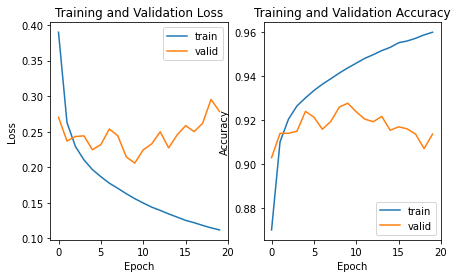

In [ ]:
for key in hist.history:
  print(key)
plt.figure(figsize=(7, 4))

ax = plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Training and Validation Loss")
plt.xticks(np.arange(0,EPOCHS+1,5),np.arange(0,EPOCHS+1,5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Training and Validation Accuracy")
plt.xticks(np.arange(0,EPOCHS+1,5),np.arange(0,EPOCHS+1,5))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='lower right')

### **Restaurer les poids du modèle sur la meilleure époque d'entraînement**


In [ ]:
model.load_weights(checkpointpath)
# S'assurer que c'est bien le meilleur modèle sur les époques d'entraînement
model.evaluate(valid_X,valid_y_enc,batch_size=256)

600/600 [==============================] - 3s 5ms/step - loss: 0.2058 - accuracy: 0.9277


[0.2057730108499527, 0.9276857376098633]

### **Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet**

In [ ]:
# Récupérer les probabilités prédites sur le jeu de validation
valid_prob = model.predict(valid_X,batch_size=256)
valid_prob.shape

(153469, 5)

In [ ]:
# Retourner la classe correspondant à la probabilité la plus haute
valid_pred = np.argmax(valid_prob,axis=1) # axe 1 car ceci concerne chaque ligne
valid_pred.shape

(153469,)

In [ ]:
# Je réencode les prédictions entre 1 et 5
valid_pred_enc = encoder.inverse_transform(valid_pred)
np.unique(valid_pred_enc)

array([1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
# Aggrégation au niveau objet
out_pred = []
unique_id = np.unique(valid_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = valid_pred_enc[np.where(valid_id==ID)]
    y_true = valid_y[np.where(valid_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
out_pred = np.vstack(out_pred)
out_pred.shape

(558, 2)

In [ ]:
# F1 score au niveau objet
f1_score(out_pred[:,0],out_pred[:,1],average='weighted')

0.9542916534352957

In [ ]:
prediction = model.predict(test_X)
test_id = np.unique(test_id)

out_pred = []
for ID in test_id :
    array = []
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = prediction[np.where(gt_id[idx_test]==ID)]
    for p in pred:
        result = np.where(p==p.max())[0][0]+1
        array.append(result)
    
    out_pred.append([ID, np.bincount(array).argmax()]) #(Vérité terrain,Prédiction majoritaire) 

out_pred = np.vstack(out_pred)
out_pred = sorted(out_pred, key=lambda id: id[0])


a=np.asarray(out_pred)
pd.DataFrame(a, columns = ["ID", "Class"]).to_csv("CNN2D/Soumission_DIDIERMARTIN.csv", index=None)

In [ ]:
df_test = pd.read_csv('CNN2D/Test_ID_Label.csv')
df = pd.read_csv('CNN2D/Soumission_DIDIERMARTIN.csv')

f1_score(df_test.Class,df.Class,average='weighted')

0.8402615500881638